In [2]:
import os
import sys

import h5py
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

sys.path.append('../../../uia_segmentation/src')

from preprocessing.resampling import resample

In [3]:
def find_largest_bounding_box_3d(arr):
    # Find the indices of non-zero elements
    z, y, x = np.nonzero(arr)

    # If there are no non-zero elements, return None or an appropriate response
    if len(z) == 0 or len(y) == 0 or len(x) == 0:
        return None

    # Find the minimum and maximum indices along each dimension
    top_left_front = (np.min(z), np.min(y), np.min(x))
    bottom_right_back = (np.max(z), np.max(y), np.max(x))

    # Return the coordinates of the bounding box
    return top_left_front, bottom_right_back

# Check minimum cropping size

In [4]:
h5f = h5py.File('/scratch_net/biwidl319/jbermeo/data/preprocessed/UIA_segmentation/USZ.h5')

### Check the cropping function is working

In [66]:
a = nib.load('/scratch_net/biwidl319/jbermeo/data/raw/USZ/02014629_KO_MCA_Checked/02014629_KO_MCA_Checked_tof.nii.gz')
arr = a.get_fdata()

In [67]:
arr.shape

(592, 768, 150)

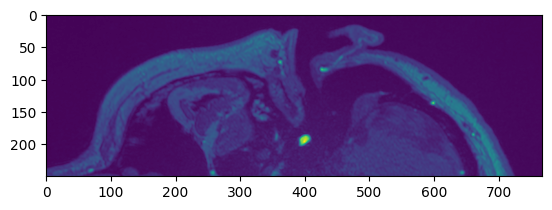

In [77]:
plt.imshow(arr[:250, :, 60])

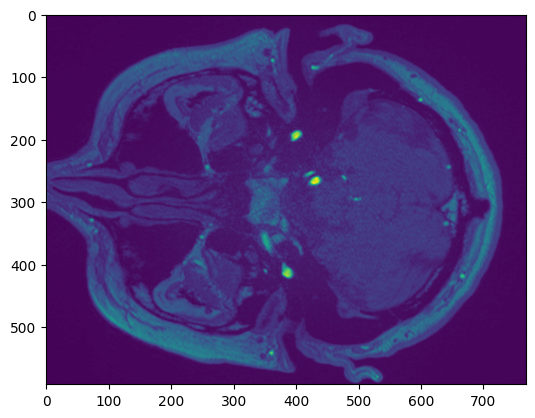

In [83]:
plt.imshow(arr[:, :, 60])

(150, 768, 592)


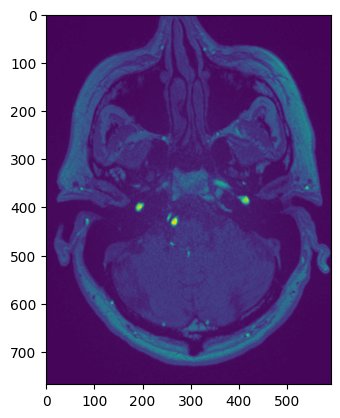

In [81]:
a = np.swapaxes(arr, 0, 2)
print(a.shape)
plt.imshow(a[60, :, :])

In [78]:
def whd_2_dhw(scan_data: np.ndarray):
    assert len(scan_data.shape) == 3, \
    f'Expected a 3D scan, but got {len(scan_data.shape)}D'
    
    scan_data = np.moveaxis(scan_data, -1, -3)
    scan_data = np.moveaxis(scan_data, -2, -1)
    scan_data = np.rot90(scan_data, k=2, axes=(-3, -2))
    
    return scan_data


b = whd_2_dhw(arr)

In [79]:
b.shape

(150, 768, 592)

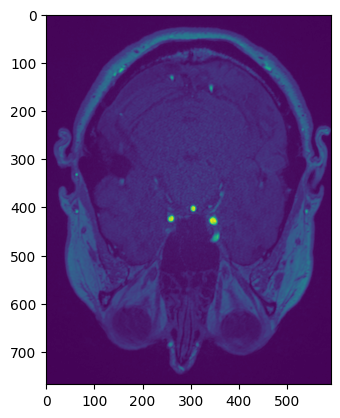

In [82]:
plt.imshow(b[60, :, :])

In [62]:
random_img = np.random.choice(list(h5f['data'].keys()))
img_group = h5f['data'][random_img]

tof = img_group['tof'][:][0]
seg = img_group['seg'][:][0] 


In [ ]:

nib.save(nib.Nifti1Image(tof, np.eye(4)), 'not_sliced_tof_around_seg.nii.gz')
nib.save(nib.Nifti1Image(seg, np.eye(4)), 'not_sliced_seg.nii.gz')

bbox_left, bbox_right = find_largest_bounding_box_3d(seg)

# Slice the tof and seg
tof = tof[bbox_left[0]:bbox_right[0], bbox_left[1]:bbox_right[1], bbox_left[2]:bbox_right[2]]
seg = seg[bbox_left[0]:bbox_right[0], bbox_left[1]:bbox_right[1], bbox_left[2]:bbox_right[2]]

In [40]:
nib.save(nib.Nifti1Image(tof, np.eye(4)), 'sliced_tof_around_seg.nii.gz')
nib.save(nib.Nifti1Image(seg, np.eye(4)), 'sliced_seg.nii.gz')

### At a resolution of (0.6, 0.3, 0.3)

In [5]:
max_shape_z = 0
max_shape_x = 0
max_shape_y = 0
shapes = []
center_points = []

for scan_group_key in h5f['data'].keys():
    img_group = h5f['data'][scan_group_key]
    labels = img_group['seg'][:][0]
   
    # Find the coordinates of the largest bounding box containing non-zero elements
    min_coords, max_coords = find_largest_bounding_box_3d(labels)
    
    # Find the center point of the bounding box wrt to original frame of reference   
    max_dims = np.array(max_coords) - np.array(min_coords)
    center_point = max_dims / 2 + np.array(min_coords)
    
    shapes.append(max_dims)
    center_points.append(center_point)
    
    if max_dims[0] > max_shape_z:
        max_shape_z = max_dims[0]
        
    if max_dims[1] > max_shape_y:
        max_shape_y = max_dims[1]
    
    if max_dims[2] > max_shape_x:
        max_shape_x = max_dims[2]
        
print(max_shape_z, max_shape_y, max_shape_x)
    

199 366 467


Text(0.5, 1.0, 'Y')

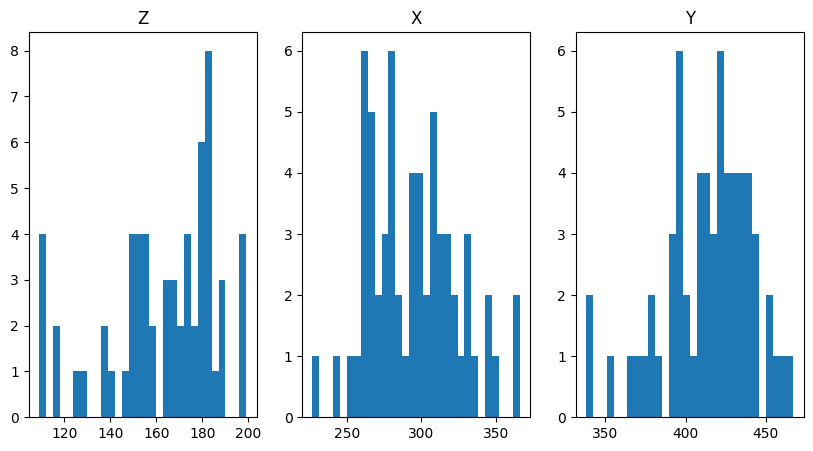

In [6]:
shapes = np.array(shapes)

# Make thre subplots, for the histogram of each column
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].hist(shapes[:, 0], bins=30) 
axes[0].set_title('Z')
axes[1].hist(shapes[:, 1], bins=30)
axes[1].set_title('X')
axes[2].hist(shapes[:, 2], bins=30)
axes[2].set_title('Y')


Text(0.5, 1.0, 'Y')

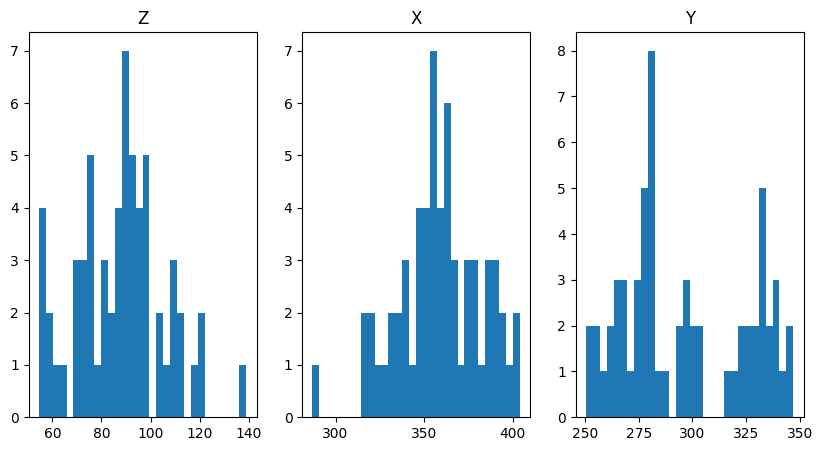

In [7]:
# Make thre subplots, for the histogram of each column for the center points
center_points = np.array(center_points)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].hist(center_points[:, 0], bins=30)
axes[0].set_title('Z')
axes[1].hist(center_points[:, 1], bins=30)
axes[1].set_title('X')
axes[2].hist(center_points[:, 2], bins=30)
axes[2].set_title('Y')

In [9]:
center_points.std(axis=0)

array([17.95381548, 23.59442583, 28.57865286])

In [33]:
np.array([max_shape_z, max_shape_y, max_shape_x]) + 30

array([229, 396, 497])

### At a resolution of (1, 0.6, 0.6)

In [35]:
target_resolution = (1, 0.6, 0.6)

In [62]:
max_shape_z = 0
max_shape_x = 0
max_shape_y = 0
shapes = []

for scan_group_key in h5f['data'].keys():
    img_group = h5f['data'][scan_group_key]
    labels = img_group['seg'][:][0]
    px = img_group['px'][()]
    py = img_group['py'][()]
    pz = img_group['pz'][()]
    orig_voxel_size = (pz, px, py)  

    affine = np.array([
        [orig_voxel_size[0], 0, 0, 0],
        [0, orig_voxel_size[1], 0, 0], 
        [0, 0, orig_voxel_size[2], 0], 
        [0, 0, 0, 1]] 
    )
    
    nib_img = nib.Nifti1Image(labels, affine)
    
    nib_img_resampled = resample(nib_img, target_resolution, order=0, is_segmenation=False)
    
    labels_resampled = nib_img_resampled.get_fdata()
    
    # Find the coordinates of the largest bounding box containing non-zero elements
    min_coords, max_coords = find_largest_bounding_box_3d(labels_resampled)
    
    max_dims = np.array(max_coords) - np.array(min_coords)
    shapes.append(max_dims)
    
    if max_dims[0] > max_shape_z:
        max_shape_z = max_dims[0]
        
    if max_dims[1] > max_shape_y:
        max_shape_y = max_dims[1]
    
    if max_dims[2] > max_shape_x:
        max_shape_x = max_dims[2]

print(max_shape_z, max_shape_y, max_shape_x)


119 183 233


Text(0.5, 1.0, 'Y')

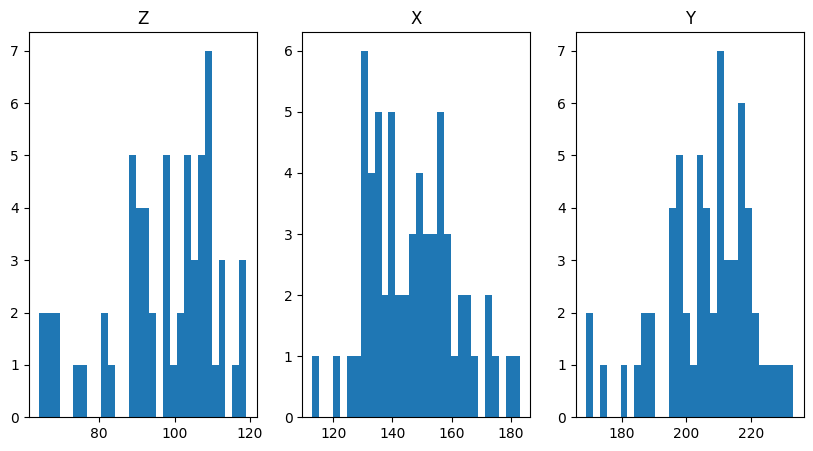

In [63]:
shapes = np.array(shapes)

# Make thre subplots, for the histogram of each column
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].hist(shapes[:, 0], bins=30) 
axes[0].set_title('Z')
axes[1].hist(shapes[:, 1], bins=30)
axes[1].set_title('X')
axes[2].hist(shapes[:, 2], bins=30)
axes[2].set_title('Y')

In [18]:
np.array([119, 183, 233]) + 30

array([149, 213, 263])

In [11]:
np.prod(np.array([119, 183, 233]) + 30)

8346831

In [15]:
np.prod([128, 256, 256])

8388608

In [20]:
np.prod(np.array([150, 214, 264])) / np.prod([128, 256, 256])

1.0102272033691406